# 评估

In [8]:
%reset -f
import os
display(os.getcwd())
import torch
import numpy as np
from PIL import Image
import cv2

from model.unet import UNet
from utils.utils import convert_pixels_v2

# 检查是否可以使用GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(2)
model.to(device)

state_dict = torch.load("weights/unet_dataset_0/unet_200.pth")
model.load_state_dict(state_dict)

cv2img = np.array(Image.open(r"data/data_dataset_voc/JPEGImages/frame_00004.jpg")).astype(np.float32)

H, W, _ = cv2img.shape
img_x = cv2.resize(cv2img, (512, 512))
img_x = np.transpose(img_x, axes=(2, 0, 1))
img_x = torch.from_numpy(img_x).type(torch.FloatTensor).to(device)
img_x = torch.unsqueeze(img_x, dim=0)

# mat = Image.open("data/data_dataset_voc/JPEGImages/frame_00034.jpg").convert("L")
# mask = Image.open("data/data_dataset_voc/SegmentationClass/frame_00034.png").convert("L")
# tensor = transform(mat).unsqueeze(0).requires_grad_(False)
# tensor_m = transform(mat).unsqueeze(0).requires_grad_(False)

pred_out = model(img_x)
pred_out, pred_out.shape

'D:\\Python\\computer_vision\\unet_water_maze'

(tensor([[[[ 6.0161,  6.5728,  6.6104,  ...,  6.6528,  6.6574,  5.7538],
           [ 6.5243,  6.8907,  6.5526,  ...,  6.7569,  7.2521,  7.0241],
           [ 6.6259,  6.7556,  6.5473,  ...,  6.5537,  6.9443,  6.8904],
           ...,
           [ 6.5545,  6.6701,  6.6633,  ...,  6.6840,  6.8916,  6.7642],
           [ 6.5446,  6.8408,  6.8466,  ...,  7.0749,  7.1409,  6.9443],
           [ 5.6837,  6.4778,  6.4406,  ...,  6.7456,  6.5279,  5.9365]],
 
          [[-6.2286, -6.6083, -6.6317,  ..., -6.7599, -6.7768, -6.0503],
           [-6.4685, -6.8838, -6.7409,  ..., -6.8679, -6.8565, -7.3428],
           [-6.9386, -7.0411, -6.9254,  ..., -6.9249, -7.0016, -7.2112],
           ...,
           [-6.9128, -6.9617, -6.9889,  ..., -7.0945, -6.9793, -7.0434],
           [-6.6975, -6.9862, -7.1683,  ..., -7.3341, -7.2480, -7.3554],
           [-6.2257, -6.7962, -6.8868,  ..., -6.9991, -6.7689, -6.2141]]]],
        device='cuda:0', grad_fn=<ConvolutionBackward0>),
 torch.Size([1, 2, 512, 512]

In [9]:
# 把张量转化为np.array：(1, 2, 256, 256)
pred = pred_out.data.cpu().numpy()
# 由输出的元素概率矩阵转化为mask矩阵
pred = np.argmax(pred, axis=1)  # axis=1表示每一行的最大值的索引 [1,c,h,w]
# 压缩掉无用的矩阵的元素维度
pred = np.float32(pred.squeeze())
pred.shape

(512, 512)

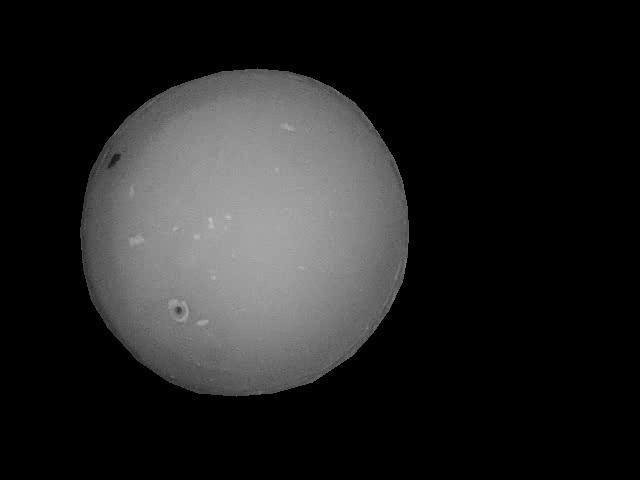

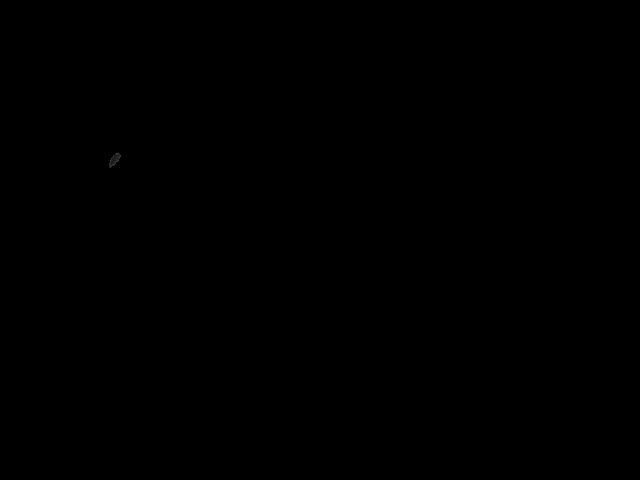

In [10]:
out = cv2.resize(pred, (640,480), interpolation=cv2.INTER_LINEAR)
out1 = np.uint8(out>0.5)
mat = Image.open(r"data/data_dataset_voc/JPEGImages/frame_00004.jpg").convert("L")
display(mat)
Image.fromarray(mat*out1)

# 视频处理

In [12]:
# 播放尝试
%reset -f
import cv2
videoname = r"data/crop_20240822WM3.avi"
capture = cv2.VideoCapture(videoname)
cv2.namedWindow("trial")
if capture.isOpened():
    while True:
        ret, img=capture.read() # img 就是一帧图片
        cv2.imshow("trial", img)
        c = cv2.waitKey(30)
        if not ret:
            break # 当获取完最后一帧就结束
        elif c == 27:
            break
else:
    print('视频打开失败！')
cv2.destroyAllWindows()

In [1]:
%reset -f
import os
import yaml
import numpy as np
from tqdm import tqdm

from model.unet import UNet
from animal.video import loading_model, generating_mask_video, recording_location
from animal.WaterMaze import RoundObject, WaterMaze

with open("config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
display(config)

model, device = loading_model(model=UNet(classes=2),
                              model_params_file=config['model_params_file'])
for f in tqdm(os.listdir(config['original_video_path'])):
    if os.path.exists(f"{config['mask_video_path']}/{f}"):
        continue
    # 生成识别视频
    generating_mask_video(original_video_path=f"{config['original_video_path']}/{f}",
                          mask_video_path=f"{config['mask_video_path']}/{f}",
                          model=model, device=device)

{'original_video_path': 'data/CropVideoByMask',
 'mask_video_path': 'data/mask',
 'location_table_path': 'data/loc',
 'model_params_file': 'weights/unet_dataset_0/unet_200.pth',
 'maze_dir': 'data/maze.npy',
 'platform_dir': 'data/platform.npy',
 'fig_save_path': 'data/roadmap'}

100%|█████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 68915.10it/s]


In [2]:
for f in tqdm(os.listdir(config['mask_video_path'])):
    if os.path.exists(f"{config['location_table_path']}/{f.replace(".avi", ".npy")}"):
        continue
    # 记录位置
    recording_location(mask_video_path=f"{config['mask_video_path']}/{f}",
                       loc_table_save_path=f"{config['location_table_path']}/{f.replace(".avi", ".npy")}")

100%|█████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 67344.89it/s]


In [3]:
# 确定迷宫及平台位置
if os.path.exists(config["maze_dir"]) and os.path.exists(config["platform_dir"]):
    maze = RoundObject().load(config["maze_dir"])
    platform = RoundObject().load(config["platform_dir"])
else:
    maze, platform = calculate_min_enclosing_circles(r"data\20240822WM2\frame_00000.jpg")
    maze.save(config["maze_dir"])
    platform.save(config["platform_dir"])

for f in tqdm(os.listdir(config['location_table_path'])):
    # 加载路径
    path = np.load(f"{config['location_table_path']}/{f}")
    # 构建水迷宫对象
    experiment = WaterMaze(path_array=path[:, 0:2],
                           maze=maze, platform=platform)
    # 绘制路径图
    experiment.visualizing_roadmap(fig_save_path=f"{config['fig_save_path']}/{f.replace(".npy", ".pdf")}",
                                   save=True)

100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [00:04<00:00, 44.67it/s]
